In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
# read in data 
npz_file = np.load('pca_data.npz')
pca_data = npz_file['pca_data']

In [6]:
# center the data around (0,0) by subtracting the mean from each feature
pca_data -= np.mean(pca_data,axis = 0)

# NOTE: from here on we'll use the "de-meaned" data

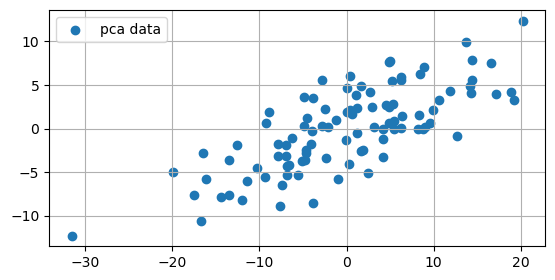

In [7]:
# plot the data
fig, ax = plt.subplots()
ax.scatter(pca_data[:,0],pca_data[:,1],label='pca data')
ax.grid()
ax.set_aspect('equal', 'box')
ax.legend()

# Part I - Scaling Data

## I-a) Normalization - change ranges of each feature to be between 0 and 1

In [8]:
# normalize pca_data
max_value_0 = max(pca_data[:,0])
min_value_0 = min(pca_data[:,0])
max_value_1 = max(pca_data[:,1])
min_value_1 = min(pca_data[:,1])

pca_data_norm_0 = [(x - min_value_0) / (max_value_0 - min_value_0) for x in pca_data[:,0]]
pca_data_norm_1 = [(x - min_value_1) / (max_value_1 - min_value_1) for x in pca_data[:,1]]

pca_data_normd = np.array([pca_data_norm_0, pca_data_norm_1]).T
print(pca_data_normd[:5])

[[0.62254152 0.56584317]
 [0.65745741 0.29078798]
 [0.71348178 0.61123889]
 [0.5652024  0.3594036 ]
 [0.6308592  0.65615071]]


## I-b) Standardization - find mean, sigma - subtract mean, divide by sigma

In [9]:
# standardize pca_data
mean_0 = np.mean(pca_data[:,0])
mean_1 = np.mean(pca_data[:,1])
std_0 = np.std(pca_data[:,0])
std_1 = np.std(pca_data[:,1])

copy = pca_data

copy[:,0] -= mean_0
copy[:,0] /= std_0

copy[:,1] -= mean_1
copy[:,1] /= std_1

pca_data_stdzd = copy

print(pca_data_stdzd[:5])

[[ 0.07030252  0.35739973]
 [ 0.26076411 -1.07802839]
 [ 0.56636972  0.59430599]
 [-0.24247487 -0.71994466]
 [ 0.11567437  0.8286869 ]]


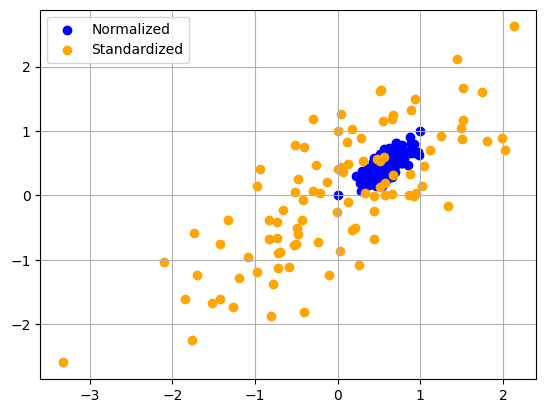

In [10]:
# plot both the normalized and standardized data on a single plot
plt.scatter(pca_data_normd[:,0], pca_data_normd[:,1], c='blue', label='Normalized')
plt.scatter(pca_data_stdzd[:,0], pca_data_stdzd[:,1], c='orange', label='Standardized')

plt.grid()
plt.legend()

%### NOTE: from here on out we'll do our PCA on the normalized data

# Part II) - Principal Component Analysis - see book for more info

##  Part II-a) sklearn implementation

In [11]:
# use the sklearn version to do PCA on the normalized data
from sklearn.decomposition import PCA
X = pca_data_normd # same data, just call it X 

# initialize the pca object, then .fit() will do heavy lifting of calculating components
pca = PCA()
pca.fit(X)

print(pca.components_)
p_hat_0 = pca.components_[0]
p_hat_1 = pca.components_[1]

[[-0.68609228 -0.72751452]
 [ 0.72751452 -0.68609228]]


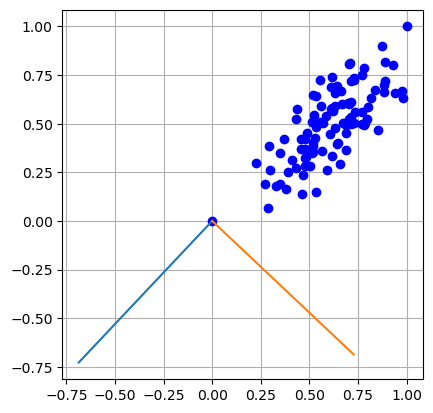

In [12]:
# plot the data and the two principal component axes vectors, starting at the origin
fig, ax = plt.subplots()
ax.plot(X[:,0],X[:,1],'bo')
ax.grid()
ax.set_aspect('equal', 'box')
ax.plot((0,p_hat_0[0]),(0,p_hat_0[1]))
ax.plot((0,p_hat_1[0]),(0,p_hat_1[1]))

## Part II-b) implementation from scratch using numpy
NOTE: this section follows the process of the author, but uses numpy arrays instead of "from scratch" data structures

In [13]:
# function that will normalize an input numpy vector, returning the normalized vector
def direction(w):
    return w / np.linalg.norm(w) if np.linalg.norm(w) != 0 else w
      
# test function
w = X[0]
print(w,direction(w))

[0.62254152 0.56584317] [0.7400014  0.67260533]


In [14]:
# demonstrate np version of dot product on first two rows of pca_data
print(np.dot(X[0,:],X[1,:]))

0.5738349254698356


In [15]:
# function that will return the sum of the directional variances of an input array of vectors (e.g. pca_data)
# in the direction of an input vector 'w'

def directional_variance(data, w):
    w_hat = direction(w)
    return sum(np.dot(v, w_hat)**2 for v in data)

w = np.array((3,2))
tmp = directional_variance(X, w)
print(tmp)

66.56372004332529


In [16]:
# function that will calculate the gradient of the directional variance with respect to w
def directional_variance_gradient(data, w):
    """
    The gradient of directional variance with respect to w
    """
    w_hat = direction(w)
    return [sum(2 * np.dot(v, w_hat) * v[i] for v in data) for i in range (len(w))]

print(directional_variance_gradient(X, w))

[102.98377270043078, 85.52324665119326]


In [17]:
# from scratch.linear_algebra
def scalar_multiply(c, v):
    return [c * v_i for v_i in v]

# from scratch.gradient_descent
def gradient_step(v, gradient, step_size):
    assert len(v) == len(gradient)
    step = scalar_multiply(step_size, gradient)
    return np.add(v, step)

# function that will perform gradient descent optimization to find the first principal component of the input data
# NOTE: here we are MAXIMIZING the variance (so not minimizing like we often see w/ optimization)
def first_principal_component(data,N = 100, step_size = 0.1):
    guess = np.random.random((data.shape[1]))
    for n in range(N):
        dv = directional_variance(data, guess)
        gradient = directional_variance_gradient(data, guess)
        guess = gradient_step(guess, gradient, step_size)
    return guess
        
p = first_principal_component(X)  
print(p)
p_hat = direction(p)
print(p_hat)

[1031.20219739  859.86034347]
[0.76802888 0.64041521]


In [18]:
# function that will return a vector in the direction of 'w' with 
# magnitude equal to the length of the projection of 'v' onto 'w'
# NOTE: normalize 'w' inside the function

def project(v,w):
    norm_w = w / np.linalg.norm(w)
    magnitude = np.dot(v, norm_w)
    return magnitude * norm_w

print(project(X[0],p))

[0.64553168 0.53827183]


In [19]:
# function that projects 'v' onto 'w' and subtracts the result from 'v'

def remove_projection_from_vector(v, w):
    return np.subtract(v, project(v,w))

print(remove_projection_from_vector(X[0],p))

[-0.02299016  0.02757134]


In [20]:
# function that removes the projections onto 'w' from an input array of vectors (like pca_data)
def remove_projection(data,w):
    output_arr = np.zeros(data.shape)
    for n in range(len(data)):
        output_arr[n] = remove_projection_from_vector(data[n], w)
    return output_arr
        
p_r = remove_projection(X,p)
print(p_r[:5])

[[-0.02299016  0.02757134]
 [ 0.12661787 -0.15184864]
 [-0.0080209   0.00961921]
 [ 0.05503207 -0.06599816]
 [-0.06399725  0.07674979]]


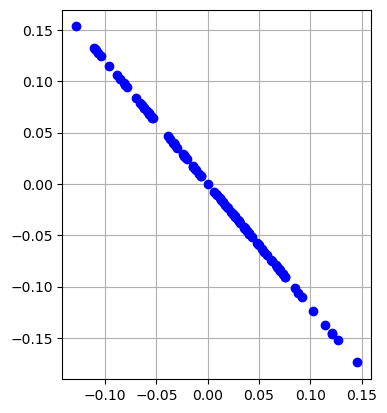

In [21]:
# plot the data with the projection removed
fig, ax = plt.subplots()
ax.plot(p_r[:,0],p_r[:,1],'bo')
ax.grid()
ax.set_aspect('equal', 'box')

In [25]:
def pca(data, num_components):
    components = np.zeros((num_components,data.shape[1]))
    for n in range(num_components):      
        component = first_principal_component(data)
        components[n] = component
        data = remove_projection(data, component)
    return components

p_components = pca(X,2)
print(p_components)

[[1035.2690184   862.21580188]
 [  -9.22776683   12.90607809]]


In [26]:
# normalize the components
p_hat_0 = direction(p_components[0])
p_hat_1 = direction(p_components[1])
print(p_hat_0,p_hat_1)

[0.76840682 0.63996168] [-0.58161958  0.81346092]


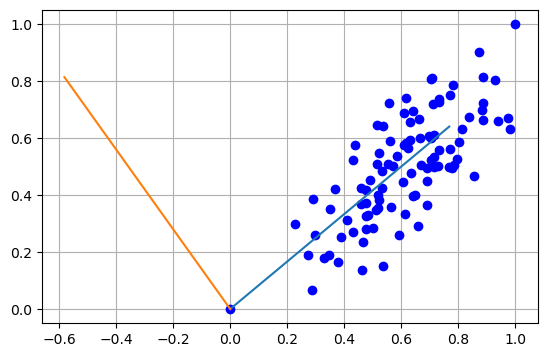

In [27]:
# plot the data and the two principal component axes vectors, starting at the origin
fig, ax = plt.subplots()
ax.plot(X[:,0],X[:,1],'bo')
ax.grid()
ax.set_aspect('equal', 'box')
ax.plot((0,p_hat_0[0]),(0,p_hat_0[1]))
ax.plot((0,p_hat_1[0]),(0,p_hat_1[1]))